# Boosting
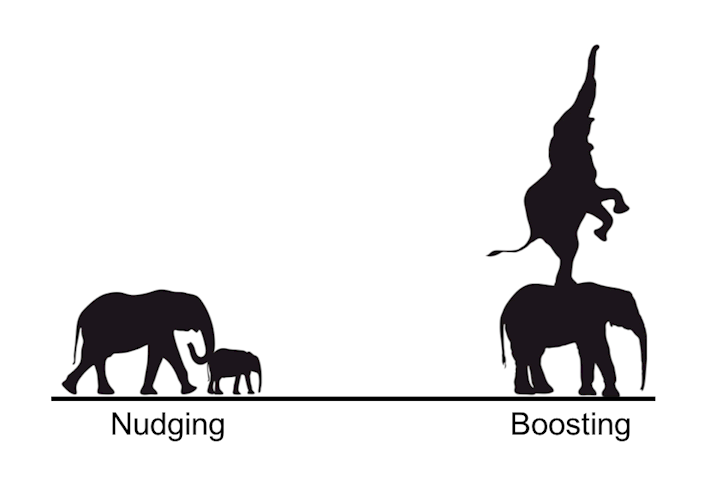

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cat
import lightgbm as lgb
import xgboost  as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix

/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
#!conda install lightgbm --yes

# Data
* Kaggle 2015 Flight Delays (https://www.kaggle.com/usdot/flight-delays/downloads/flight-delays.zip/1)

In [88]:
flightDF  = pd.read_csv('./flight-delays/flights.csv')
airportDF = pd.read_csv('./flight-delays/airports.csv')
airlineDF = pd.read_csv('./flight-delays/airlines.csv')

/Users/wilsons/anaconda3/envs/pyjup/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
flightDF.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object

In [4]:
flightDF.head()

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      1    1            4      AS             98      N407AS   
1  2015      1    1            4      AA           2336      N3KUAA   
2  2015      1    1            4      US            840      N171US   
3  2015      1    1            4      AA            258      N3HYAA   
4  2015      1    1            4      AS            135      N527AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE      ...        \
0            ANC                 SEA                    5      ...         
1            LAX                 PBI                   10      ...         
2            SFO                 CLT                   20      ...         
3            LAX                 MIA                   20      ...         
4            SEA                 ANC                   25      ...         

   ARRIVAL_TIME  ARRIVAL_DELAY  DIVERTED  CANCELLED  CANCELLATION_REASON  \
0         408.0          -22.0         0          0                  NaN   
1         741.0           -9.0         0          0                  NaN   
2         811.0            5.0         0          0                  NaN   
3         756.0           -9.0         0          0                  NaN   
4         259.0          -21.0         0          0                  NaN   

   AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  \
0               NaN             NaN            NaN                  NaN   
1               NaN             NaN            NaN                  NaN   
2               NaN             NaN            NaN                  NaN   
3               NaN             NaN            NaN                  NaN   
4               NaN             NaN            NaN                  NaN   

   WEATHER_DELAY  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 31 columns]

In [5]:
airportDF.head()

IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
1       ABI             Abilene Regional Airport      Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   

   LATITUDE  LONGITUDE  
0  40.65236  -75.44040  
1  32.41132  -99.68190  
2  35.04022 -106.60919  
3  45.44906  -98.42183  
4  31.53552  -84.19447

In [6]:
airlineDF.head()

IATA_CODE                 AIRLINE
0        UA   United Air Lines Inc.
1        AA  American Airlines Inc.
2        US         US Airways Inc.
3        F9  Frontier Airlines Inc.
4        B6         JetBlue Airways

# Processing
* Trim down the dataset for this example notebook
* We're emphasizing and looking at boosting rather than trying to optimize the accuracy rate
* Three simplifications
 * Trim features
 * Drop missing
 * Downsample to equal classes and smaller size

## Features

In [7]:
keepCols = ['MONTH',
            'DAY_OF_WEEK',
            'AIRLINE',
            'ORIGIN_AIRPORT',
            'DESTINATION_AIRPORT',
            'SCHEDULED_DEPARTURE',
            'SCHEDULED_ARRIVAL',
            'SCHEDULED_TIME',
            'DISTANCE',
            'ARRIVAL_DELAY',
            'CANCELLED'
]
df = flightDF[keepCols].copy()

## Missing Data
* We have a small amount of missing arrival delays
* Rather than impute them to mean / median we'll drop them for simplicity

In [10]:
missingDF = pd.DataFrame(df.isna().mean().round(4) * 100)
missingDF.reset_index().rename(columns={'index': 'Feature', 0: 'Percent Missing'})

Feature  Percent Missing
0                 MONTH             0.00
1           DAY_OF_WEEK             0.00
2               AIRLINE             0.00
3        ORIGIN_AIRPORT             0.00
4   DESTINATION_AIRPORT             0.00
5   SCHEDULED_DEPARTURE             0.00
6     SCHEDULED_ARRIVAL             0.00
7        SCHEDULED_TIME             0.00
8              DISTANCE             0.00
9         ARRIVAL_DELAY             1.81
10            CANCELLED             0.00
11                CLASS             0.00

In [11]:
df = df.dropna()

## Classification

In [34]:
## Balance Classes
delay  = df[df.ARRIVAL_DELAY > 0].sample(1000000)
ontime = df[df.ARRIVAL_DELAY <= 0].sample(1000000)
df = pd.concat([delay, ontime])

In [35]:
df['CLASS'] = np.where(df.ARRIVAL_DELAY <= 0, 'ONTIME', 'DELAY')

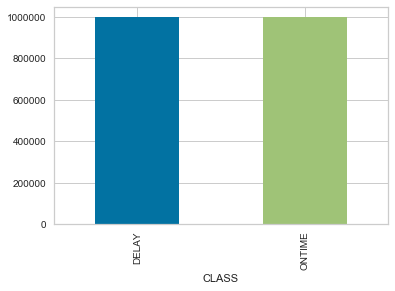

In [36]:
df.groupby('CLASS').size().plot.bar()

# EDA - Further

## Top Arrival Airports & Airlines

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text yticklabel objects>)

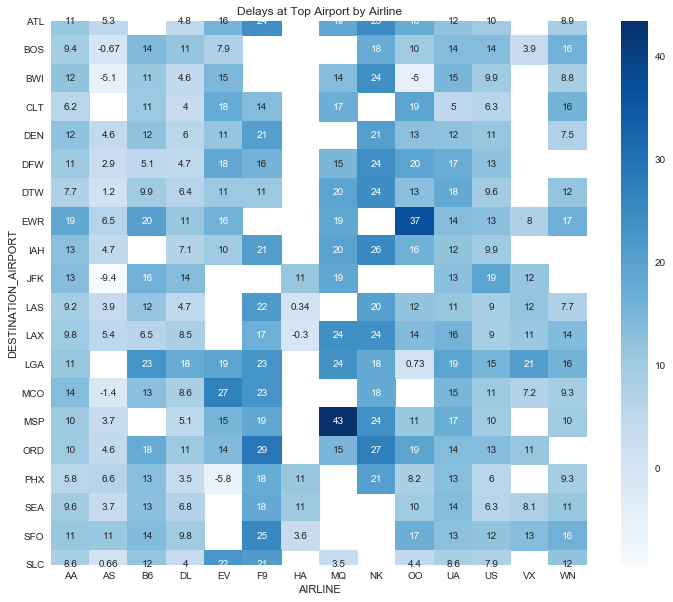

In [37]:
top = 20
topAirports = df.groupby('DESTINATION_AIRPORT').size() \
    .sort_values(ascending=False) \
    .head(top) \
    .index \
    .tolist()

pvt = df[df.DESTINATION_AIRPORT.isin(topAirports)] \
    .groupby(['AIRLINE', 'DESTINATION_AIRPORT']) \
    .agg({'ARRIVAL_DELAY': 'mean'}) \
    .reset_index() \
    .pivot(index='DESTINATION_AIRPORT', columns='AIRLINE', values='ARRIVAL_DELAY')

plt.figure(figsize=(12,10))
plt.title('Delays at Top Airport by Airline')
sns.heatmap(pvt, cmap='Blues', annot=True)
plt.yticks(rotation=0) 

## Airline Delay Distribution

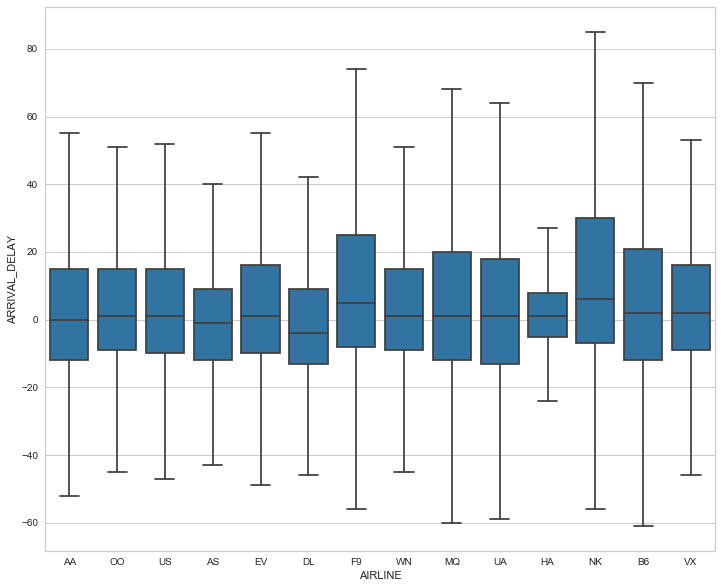

In [38]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.AIRLINE, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            color='#1f77b4')

## Delays by Month

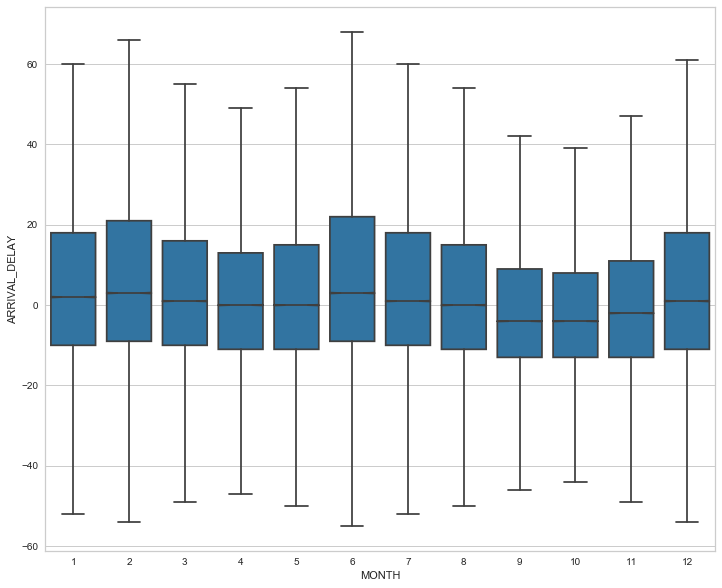

In [39]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.MONTH, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            notch=True,
            color='#1f77b4')

## Delays by Day of Week

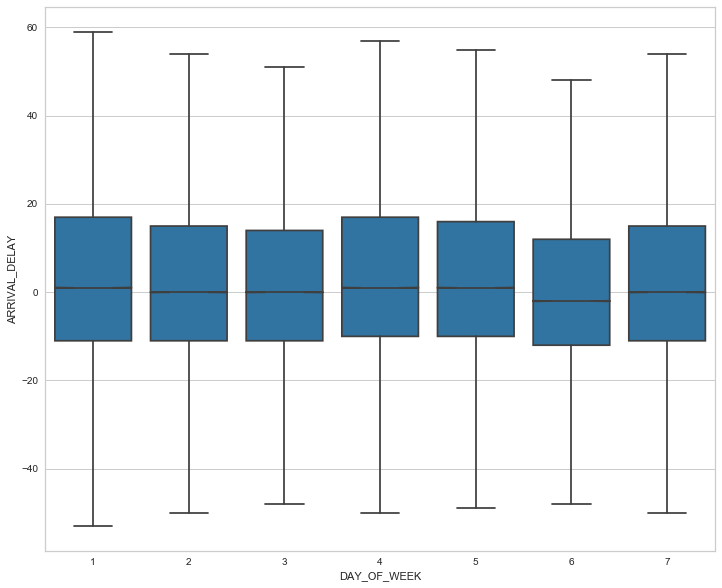

In [40]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df.DAY_OF_WEEK, 
            y=df.ARRIVAL_DELAY, 
            showfliers=False,
            notch=True,
            color='#1f77b4')

## Distance

<Figure size 1080x864 with 0 Axes>

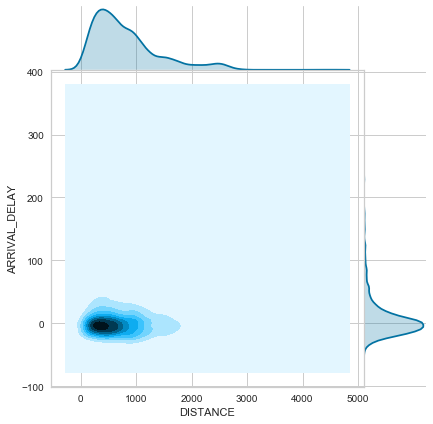

In [57]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot('DISTANCE', 'ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

## Scheduled Departure

<Figure size 1080x864 with 0 Axes>

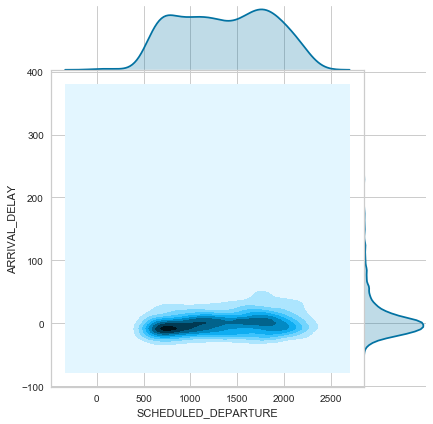

In [58]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot('SCHEDULED_DEPARTURE', 'ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

## Scheduled Arrival

<Figure size 1080x864 with 0 Axes>

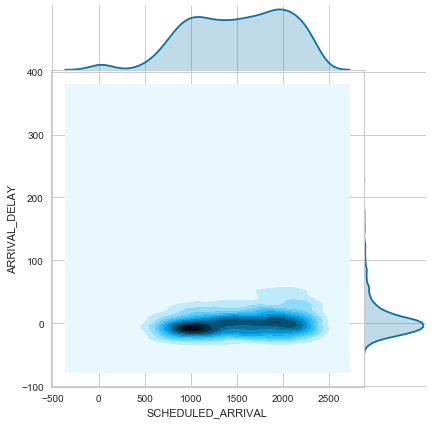

In [59]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot('SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

## Scheduled Time

<Figure size 1080x864 with 0 Axes>

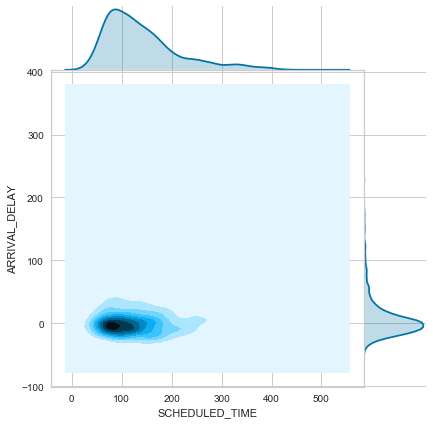

In [60]:
plt.figure(figsize=(15,12))
deltaDF = df.sample(2000, random_state=5) 
sns.jointplot('SCHEDULED_TIME', 'ARRIVAL_DELAY', data=deltaDF, kind='kde', space=0, color='b')

# Pipeline

In [41]:
df.dtypes

MONTH                    int64
DAY_OF_WEEK              int64
AIRLINE                 object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_ARRIVAL        int64
SCHEDULED_TIME         float64
DISTANCE                 int64
ARRIVAL_DELAY          float64
CANCELLED                int64
CLASS                   object
dtype: object

In [42]:
featuresNumeric = [
    'DISTANCE',
    'SCHEDULED_DEPARTURE',
    'SCHEDULED_ARRIVAL',
    'SCHEDULED_TIME'
]
transformerNumeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
], verbose=True)


featuresCategorical = [
    'MONTH',
    'DAY_OF_WEEK',
    'AIRLINE',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT'
]
transformerCategorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(categories='auto', handle_unknown='ignore'))
], verbose=True)


preprocessor = ColumnTransformer(transformers=[
        ('num' , transformerNumeric,     featuresNumeric),
        ('cat' , transformerCategorical, featuresCategorical)
])

In [43]:
X = df.copy()
X = X.sample(frac=0.25, random_state=23)
X.MONTH       = X.MONTH.astype(str)
X.DAY_OF_WEEK = X.DAY_OF_WEEK.astype(str)
X.AIRLINE     = X.AIRLINE.astype(str)
X.ORIGIN_AIRPORT      = X.ORIGIN_AIRPORT.astype(str)
X.DESTINATION_AIRPORT = X.DESTINATION_AIRPORT.astype(str)
print(X.dtypes)

y = X.CLASS
X = X.drop(['CLASS', 'CANCELLED', 'ARRIVAL_DELAY'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.where(y_train == 'ONTIME', 0, 1)
y_test  = np.where(y_test  == 'ONTIME', 0, 1)

MONTH                   object
DAY_OF_WEEK             object
AIRLINE                 object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_ARRIVAL        int64
SCHEDULED_TIME         float64
DISTANCE                 int64
ARRIVAL_DELAY          float64
CANCELLED                int64
CLASS                   object
dtype: object


# Metrics

In [45]:
def measureErrors(y, y_hat):
    accuracy = accuracy_score(y, y_hat)
    print('Accuracy', accuracy)
    print('Confusion Matrix')
    print(confusion_matrix(y, yhat))
    print('Classification Report')
    print(classification_report(y_hat, y))
    return accuracy

In [46]:
resultsDF = pd.DataFrame(columns=['Accuracy'])

# Bagging vs Boosting 
* Bagging = Bootstrap Aggregating
 * Leverage high variance (overfitting) unstable learners
* Boosting
 * Combine high bias (underfitting) stable learnings 

## Data
* Bagging  - Each model pulls a random subsample of the entire dataset
* Boosting - Data is incrementally built giving more preference to misclassified datapoints

## Models
* Bagging
 * Each model gets an equal vote
 * Models can be built in parallel
* Boosting
 * Model is incrementally built
 * Model is sequentually built
 
https://bradzzz.gitbooks.io/ga-dsi-seattle/dsi/dsi_06_trees_methods/3.1-lesson/readme.html

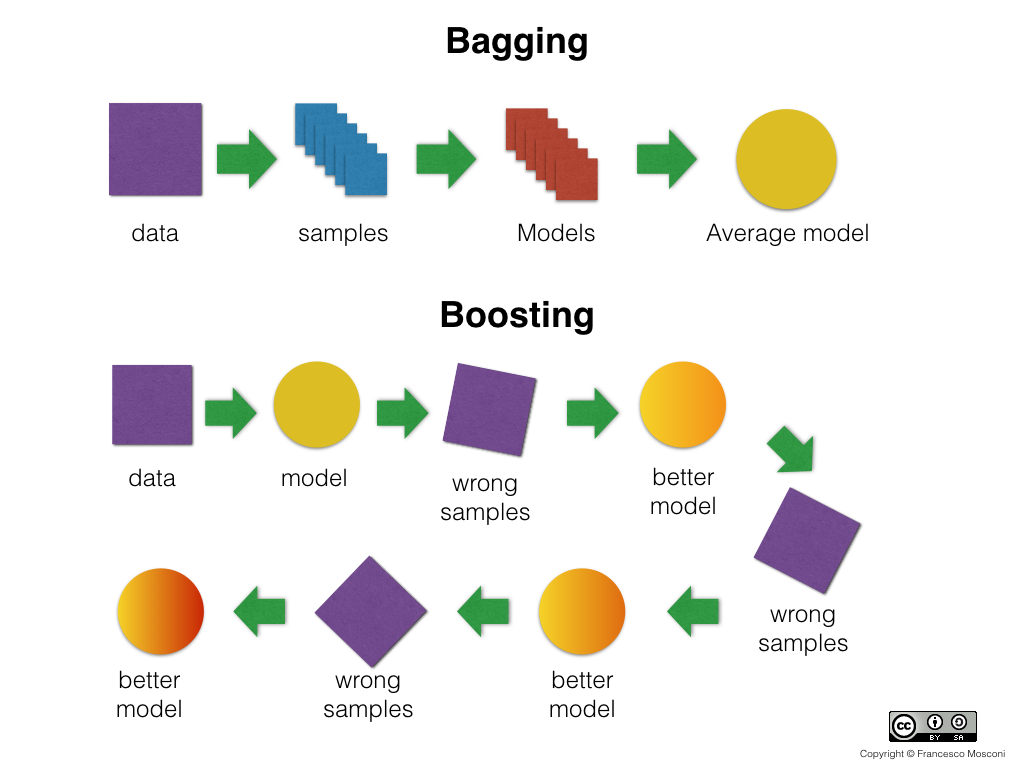

# AdaBoost - Adaptive Boosting
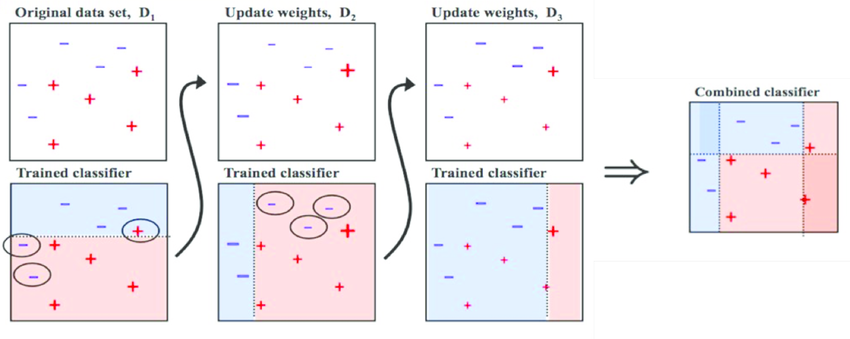

## Weak Learner
* Deault = DecisionTreeClassifier(max_depth=1)
* Best split chosen based on Information Gain 
 * Parent Entropy - Mean(Child Entropy)
* Plug in your own (SVC for example)
* Ever played Guess Who?

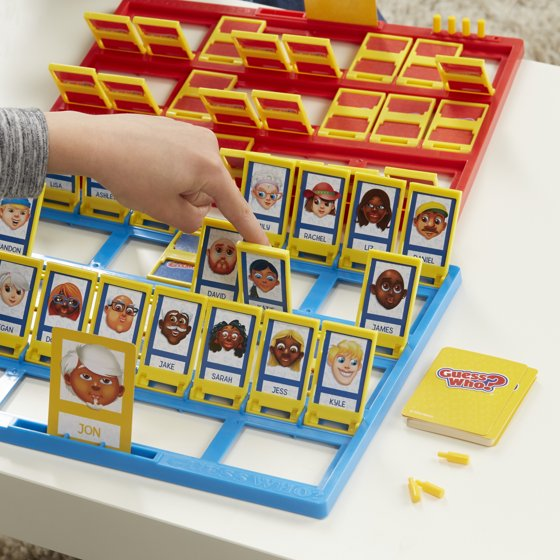

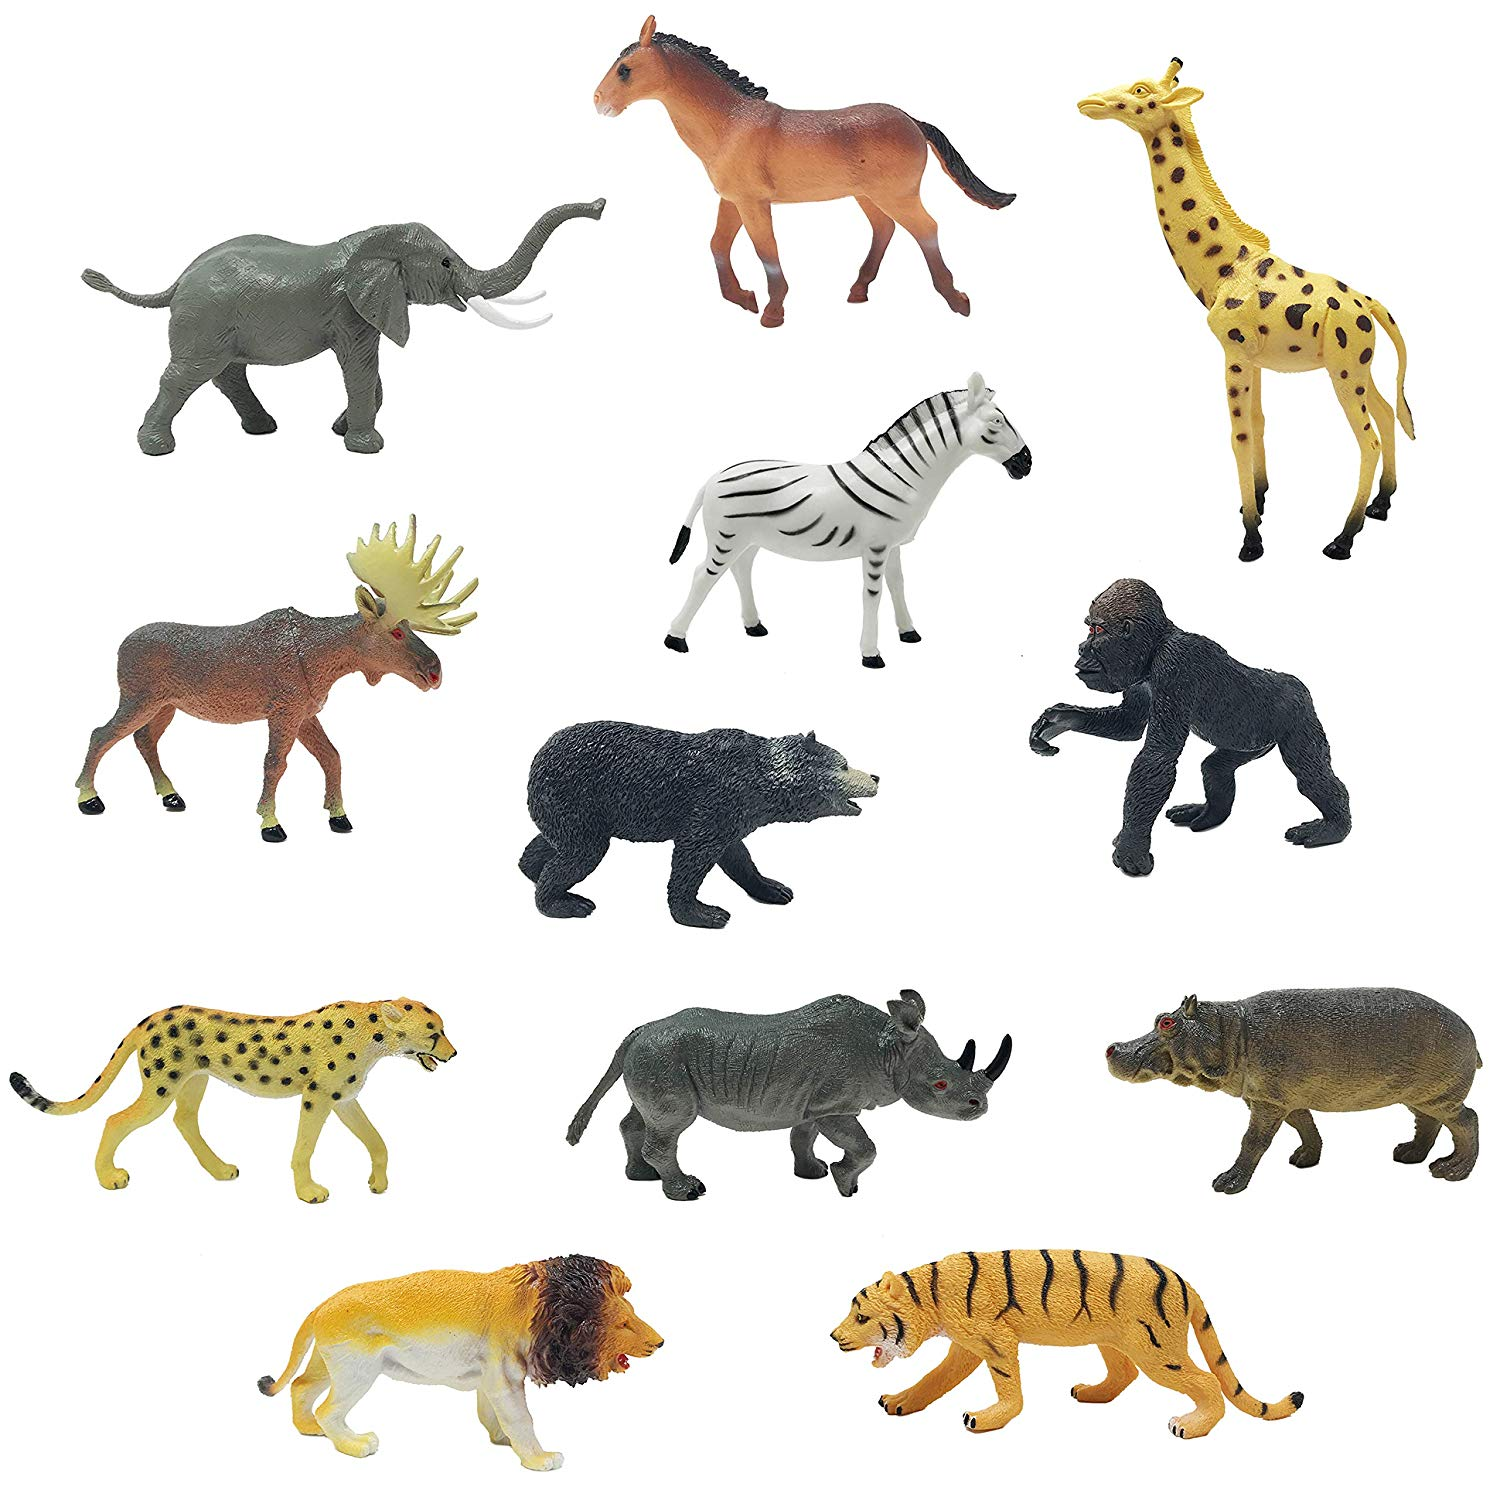

## Algorithm
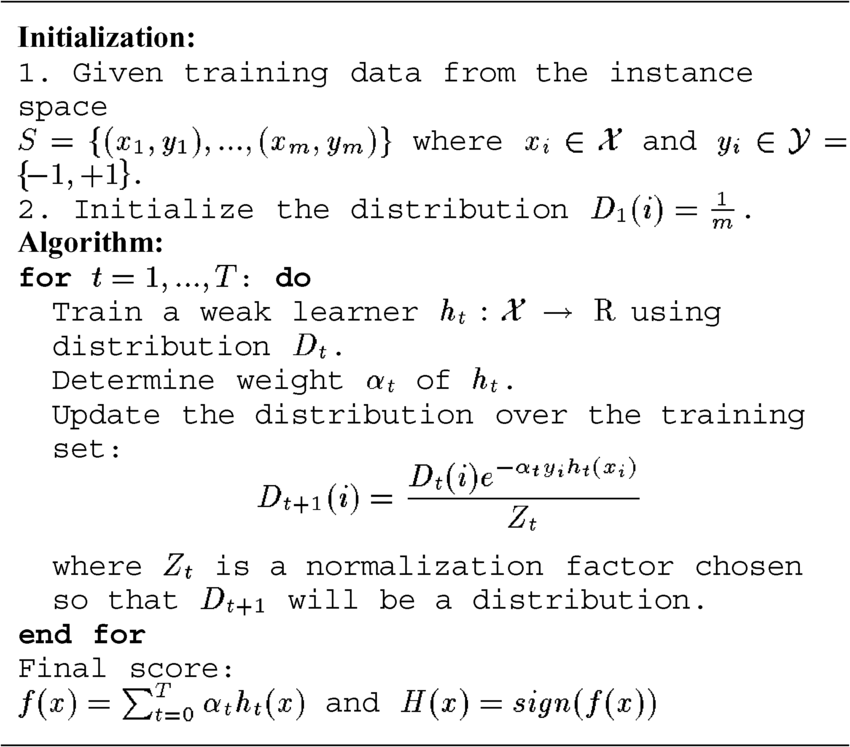

## Weighting
* Weighting - starts at 1/n for each
* Updated at each iteration
 * Correctly Classified = Lower Weight
 * Incorrectly Classified = Lower Weight

## Convergence
* After n Rounds of boosting
* Early Stopping
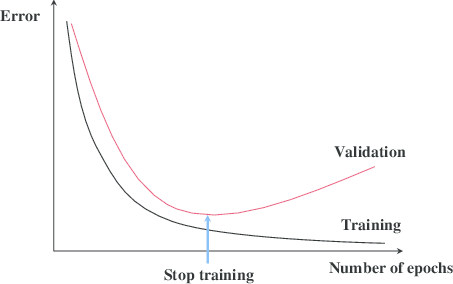

## Fit Model

In [47]:
ada = AdaBoostClassifier(n_estimators=50)
pipe = Pipeline([('pp', preprocessor),
                ('classifier', ada)])
pipe.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.2s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.3s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   1.0s


Pipeline(memory=None,
         steps=[('pp',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                       

## Predict

In [48]:
yhat = pipe.predict(X_test)

## Score Model

In [49]:
acc = measureErrors(y_test, yhat)
resultsDF.loc['AdaBoost'] = [acc]

Accuracy 0.58339
Confusion Matrix
[[27647 22244]
 [19417 30692]]
Classification Report
              precision    recall  f1-score   support

           0       0.55      0.59      0.57     47064
           1       0.61      0.58      0.60     52936

    accuracy                           0.58    100000
   macro avg       0.58      0.58      0.58    100000
weighted avg       0.59      0.58      0.58    100000



## Visualize

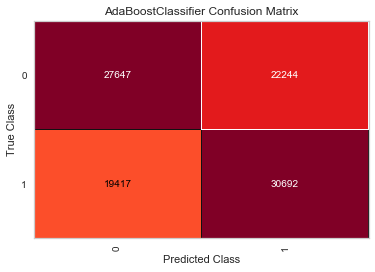

In [50]:
visualizer = ConfusionMatrix(pipe, is_fitted=True)
visualizer.score(X_test, y_test)
visualizer.poof()

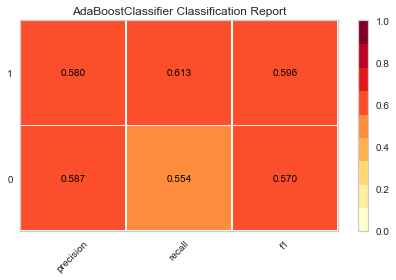

In [51]:
visualizer = ClassificationReport(pipe, is_fitted=True)
visualizer.score(X_test, y_test)
visualizer.poof()

# AdaBoost in Action

# XGBoost - eXtreme Gradient Boosting
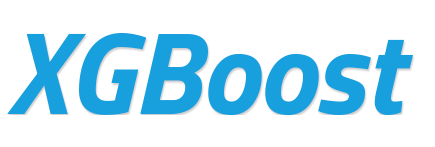

* XGBoost became the top kaggle algorithm for structured data
* Features
 * Automatic handling of missing data
 * Built in cross-validation
 * Regularization to avoid overfitting
 * Parallel building
 * Customized loss functions
* Variety of Problems
 * Classification
 * Regression
 * Ranking

## Loss Function + Regularization

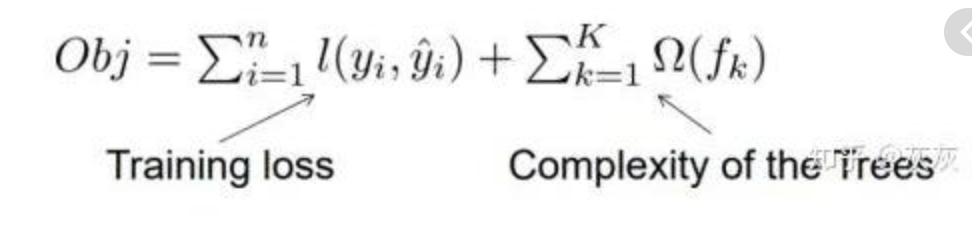

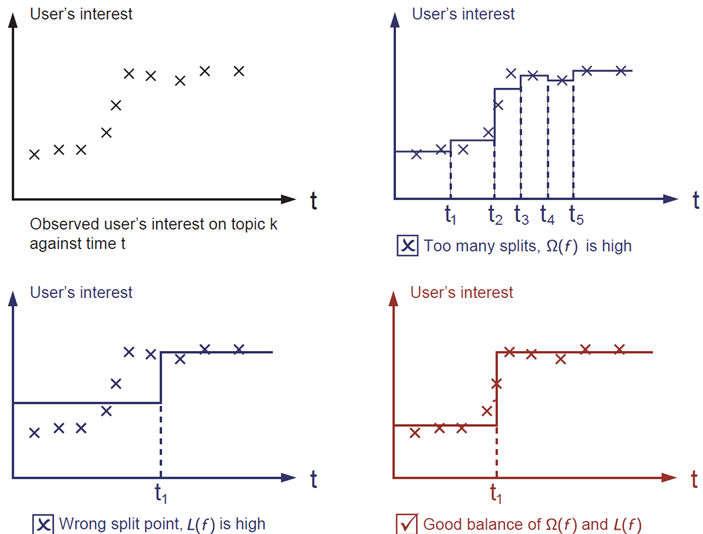

## Tree Complexity
* Max Depth to control complexity
* Trees typically built level-wise
* Practical Advice
 * 3 or 5 is usually sufficient
 * Good parameter to hypertune
 * Have heard of using very large depth trees (30+)

## Histogram Tree Building
* Finding the optimal split is time conumsing
 * Proportional to number of splits
 * But, small changes in split don't make big changes in performance
* Split features into bins & check splits on bins
* Tradeoff
 * Small number of bins = Faster, Less Accurate
 * Large number of bins (@ limit = bin per split) = Slower, More Accurate
* Finding the correct binning
 * Trivial binning (equal interval) will often be unbalanced
 * Exact : identify best split
 * Approx : tree-method will compute new bins on each split
 * Hist : tree-method will compute bins once & reuse 
 * Auto : Depends on dagtaset
   * Small -> Exact
   * Large -> Approx
* Hist building reduces BigO
 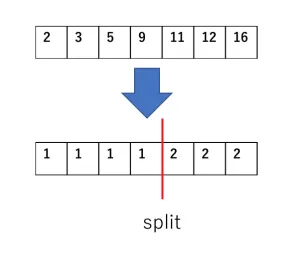

## Gradient

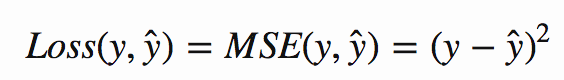

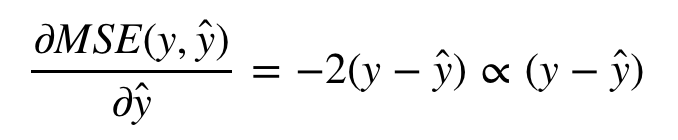

## Learning Rate
* Large learning rates
 * 1.0 considered large / full step on gradient
 * Faster convergence
 * Overshoot or miss minima
* Smaller learning rate
 * Slower to converge
 * More likely to find good minima
 * Advice - smallest learning rate you can tolerate

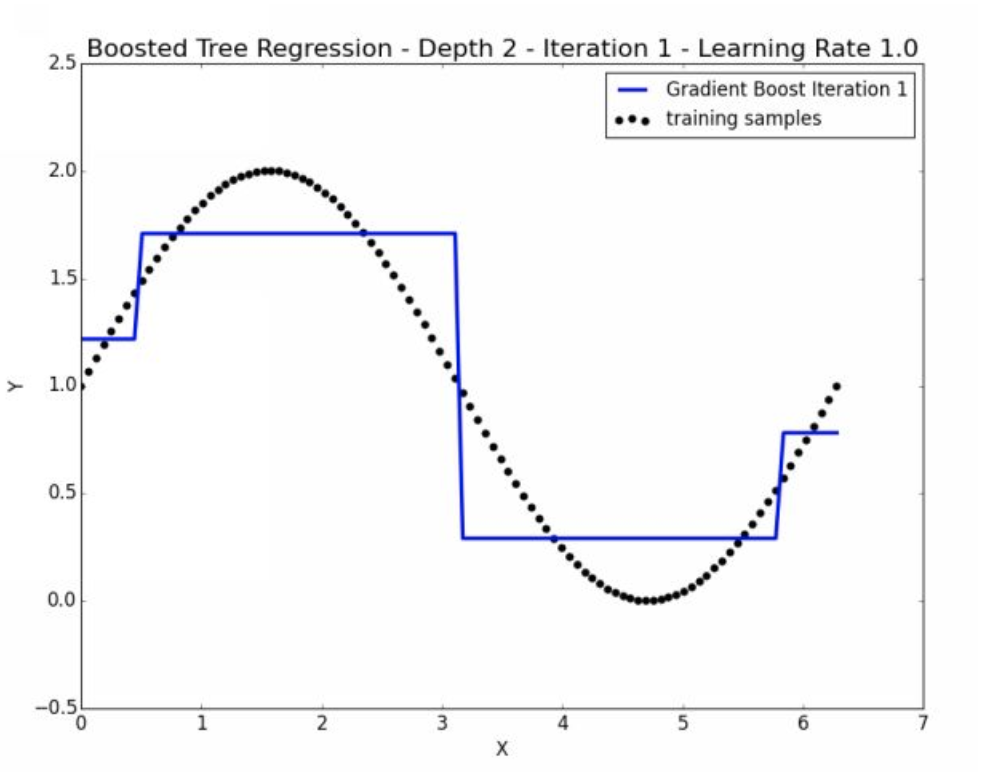

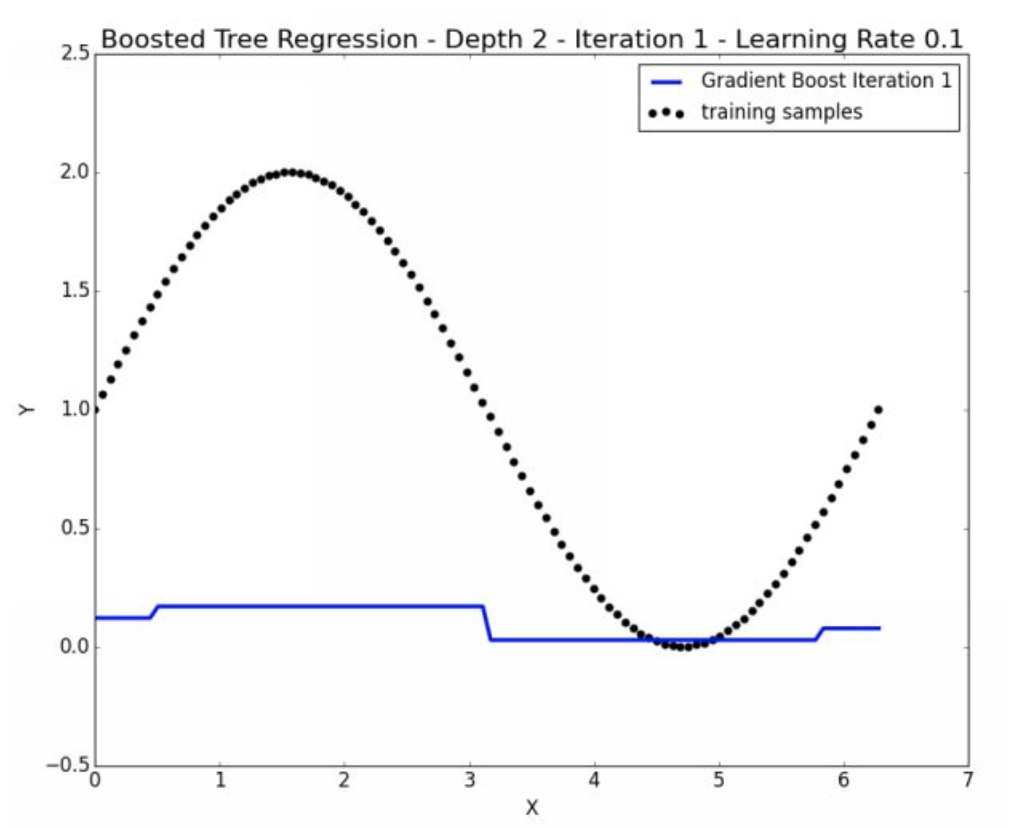

## Fit Model

In [62]:
bst = xgb.XGBRegressor(n_estimators=10000, 
                       max_depth=10, 
                       objective='binary:logistic',
                       learning_rate=0.1, 
                       tree_method='auto',
                       verbosity=1)

In [63]:
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=1337)

In [64]:
pipe = Pipeline(steps=[('preprocess', preprocessor)])
X_prep_train = pipe.fit_transform(X_train_xgb, y_train_xgb)
X_prep_val   = pipe.transform(X_val_xgb)
X_prep_test  = pipe.transform(X_test)

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.2s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.2s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   0.8s


In [65]:
eval_set = [(X_prep_val, y_val_xgb)]
bst.fit(X_prep_train, y_train_xgb, 
        early_stopping_rounds=5,
        eval_metric=['logloss'], 
        eval_set=eval_set, 
        verbose=True)

[0]	validation_0-logloss:0.688957
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.685501
[2]	validation_0-logloss:0.682797
[3]	validation_0-logloss:0.680267
[4]	validation_0-logloss:0.67824
[5]	validation_0-logloss:0.676493
[6]	validation_0-logloss:0.675027
[7]	validation_0-logloss:0.673788
[8]	validation_0-logloss:0.672628
[9]	validation_0-logloss:0.671608
[10]	validation_0-logloss:0.670765
[11]	validation_0-logloss:0.669929
[12]	validation_0-logloss:0.669192
[13]	validation_0-logloss:0.668597
[14]	validation_0-logloss:0.668121
[15]	validation_0-logloss:0.667664
[16]	validation_0-logloss:0.667191
[17]	validation_0-logloss:0.666667
[18]	validation_0-logloss:0.666163
[19]	validation_0-logloss:0.665733
[20]	validation_0-logloss:0.665264
[21]	validation_0-logloss:0.664915
[22]	validation_0-logloss:0.664582
[23]	validation_0-logloss:0.664327
[24]	validation_0-logloss:0.664045
[25]	validation_0-logloss:0.6638
[26]	validation_0-logloss:0.663543
[

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=None, n_estimators=10000, n_jobs=1,
             nthread=None, objective='binary:logistic', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, tree_method='auto', verbosity=1)

## Predict

In [66]:
pred  = bst.predict(X_prep_test, bst.best_iteration)
proba = np.exp(pred) / (1 + np.exp(pred))
yhat  = np.where(proba > 0.5, 1, 0)

## Score Model

In [67]:
acc = measureErrors(y_test, yhat)
resultsDF.loc['XGBoost'] = [acc]

Accuracy 0.60834
Confusion Matrix
[[29631 20260]
 [18906 31203]]
Classification Report
              precision    recall  f1-score   support

           0       0.59      0.61      0.60     48537
           1       0.62      0.61      0.61     51463

    accuracy                           0.61    100000
   macro avg       0.61      0.61      0.61    100000
weighted avg       0.61      0.61      0.61    100000



# LightGBM
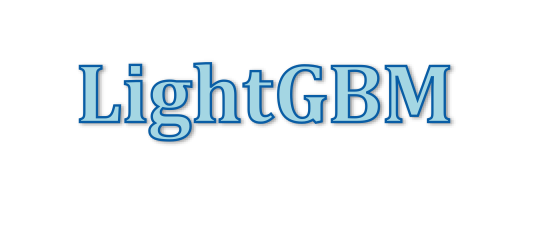

* Relevant Papers / Blogs
 * https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf
 * https://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/
* **Faster Training Time**
 * Gradient-Based One Side Sampling (GOSS)
 * Exclusive Feature Bundling
* Categorical Handling
 * Label Encode for better performance
 * Support for missing values
* Parallel Improvements
 * Feature Parallel
 * Data Parallel

## LightGBM
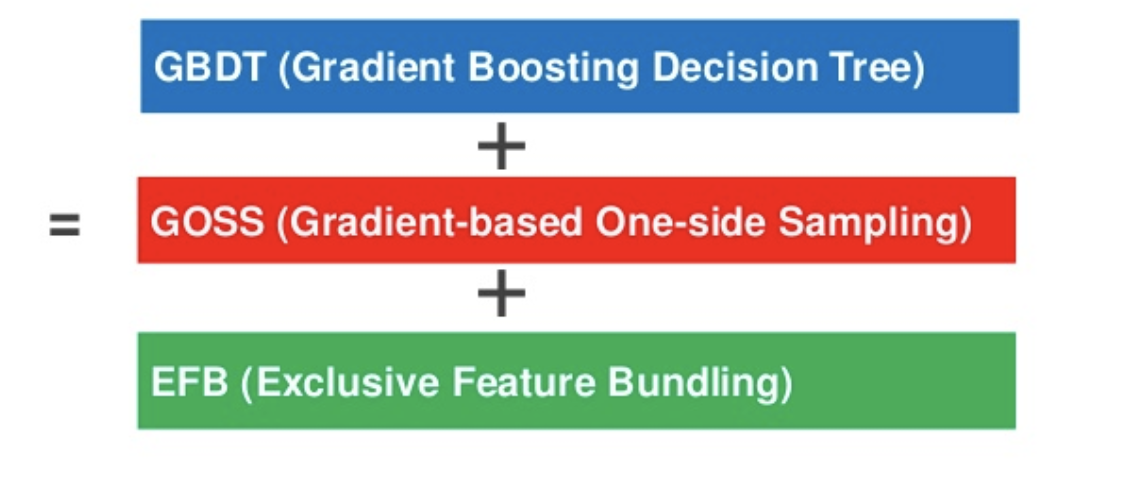

## Tree
* Level-wise
 * Constraint creates a balanced tree
 * A form of regularization (can't grow deep)
 * XGBoost default (switch with the hist tree-method)
 * Not available in lightGBM
* Leaf-wise
 * Creates splits that reduce loss the most (i.e. biggest info gain)
 * More prone to overfit
 * More flexible
* Know your tree policy when applying level or leaf
 * num_leaves & max_depth
 * Restricting leaves can still lead to a deep tree with leaf-wise growth
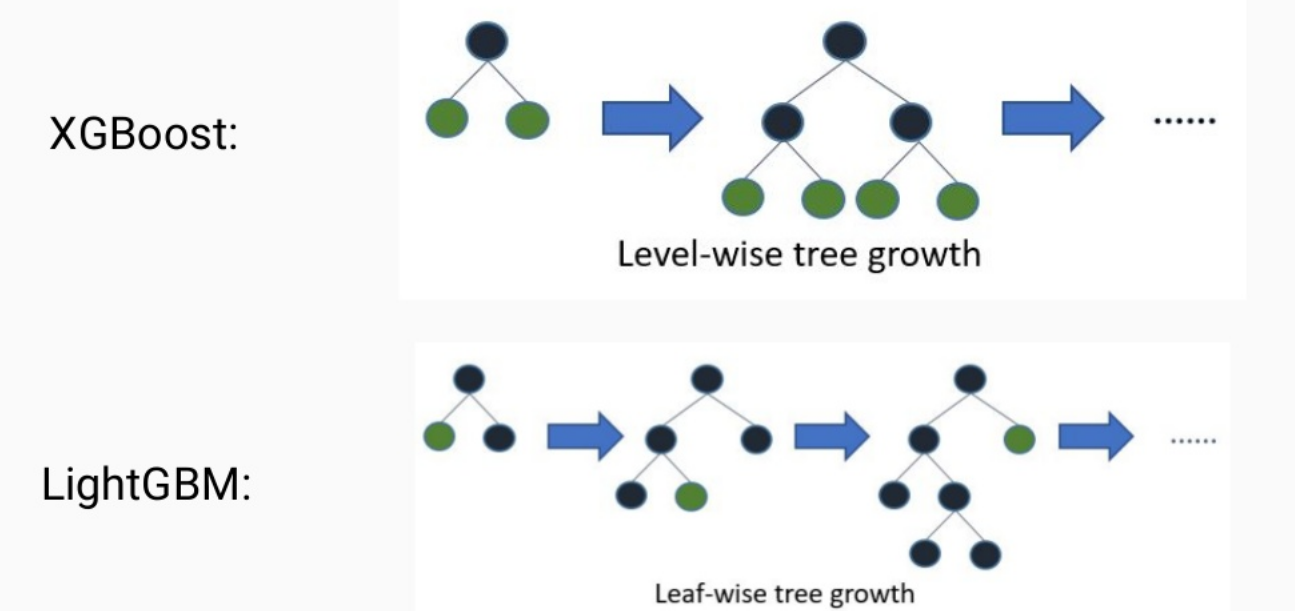

## Gradient One-Sided Sampling
* How do we subsample the data?
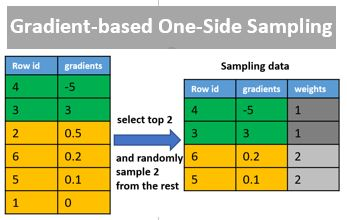

## Exclusive Feature Bundling
* Reduce Big O complexity
 * From O(Features * Data)
 * To O(Features * Bundled Data)
* Mutually exclusive features can be combined
* In practice, we encounter this frequently
 * For example : No flights from PDX to SVO

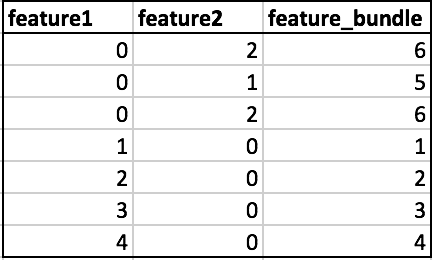

## Fit Model

In [68]:
pipe = Pipeline([('pp', preprocessor),
                ('classifier', lgb.LGBMClassifier())])

In [69]:
pipe.fit(X_train, y_train, 
         classifier__verbose=True)

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.3s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.3s
[Pipeline] ............ (step 2 of 2) Processing onehot, total=   1.0s


Pipeline(memory=None,
         steps=[('pp',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                       

## Predict

In [70]:
pred = pipe.predict(X_test)

## Score Model

In [71]:
acc = measureErrors(y_test, pred)
resultsDF.loc['LightGBM'] = acc

Accuracy 0.60427
Confusion Matrix
[[29631 20260]
 [18906 31203]]
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.61      0.60     49056
           1       0.61      0.60      0.61     50944

    accuracy                           0.60    100000
   macro avg       0.60      0.60      0.60    100000
weighted avg       0.60      0.60      0.60    100000



# CatBoost
* Features good default parameter values (avoid hypertuning)
* **Categorical support** (think R categories - no need to OHE)
* Scalable GPU learning
* Uses a novel gradient boosting scheme to improve accuracy
* Overfitting detector (early stop)
* **Fast predictions**
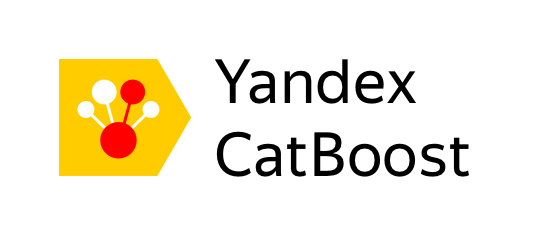

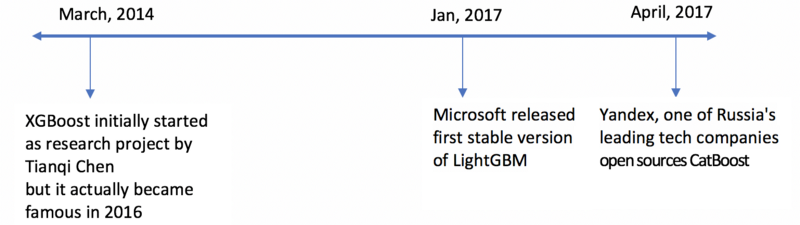

## Algorithm
* https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2
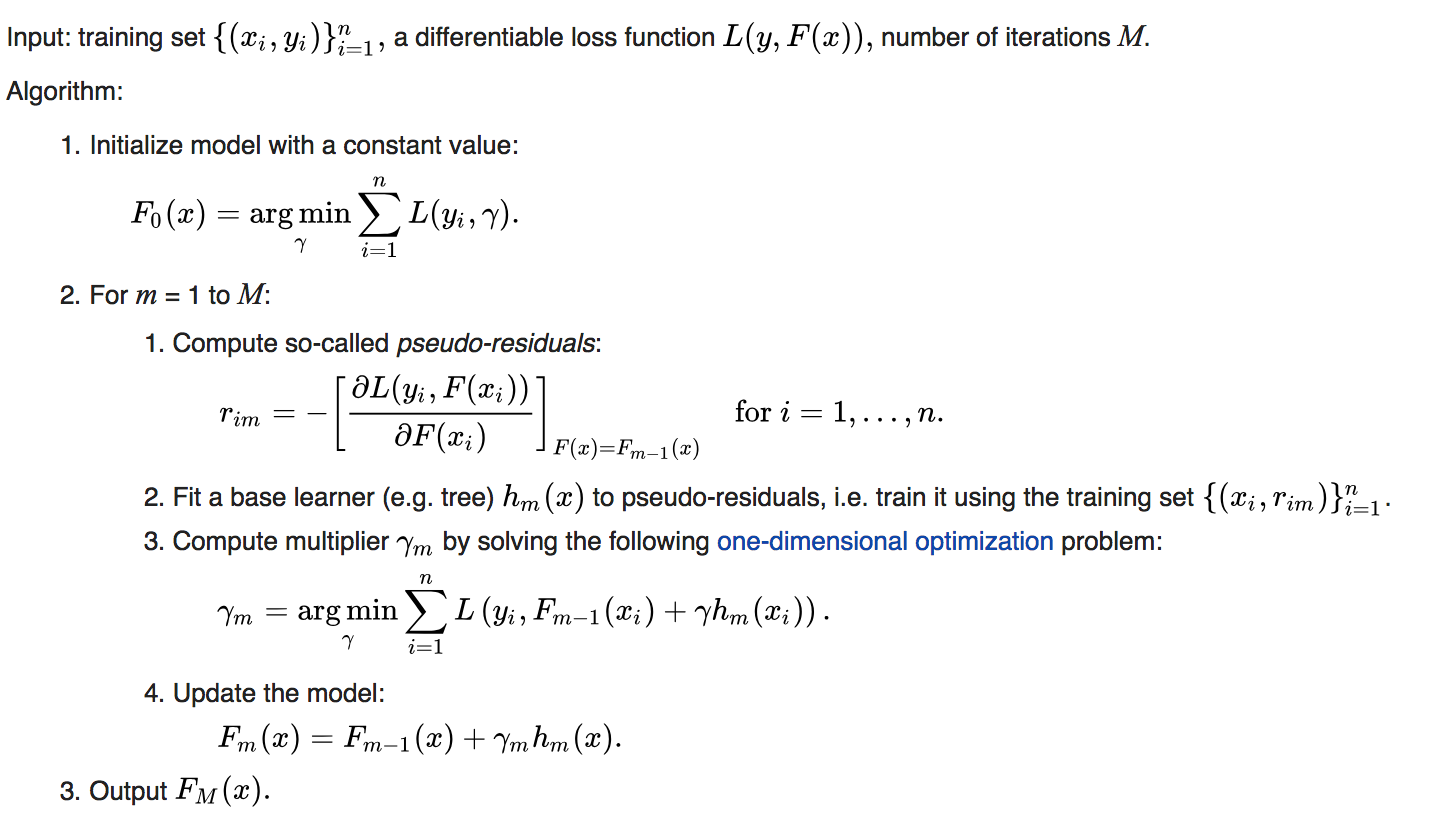

## Categorical Features

### Ordered Target Statistic
* Makes use of target mean encoding
* Fights "leakage" of target into features
* Order observations, use seen history to estimate target
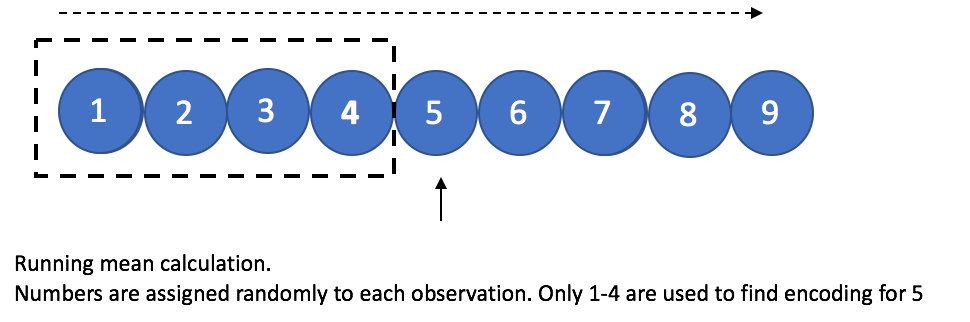

### One Hot Encoding
* CatBoost automatically handles categorical -> one hot
* Controlled with the one_hot_max_size
* Do **not** one hot encode in preprocessing

### Ordered Boosting
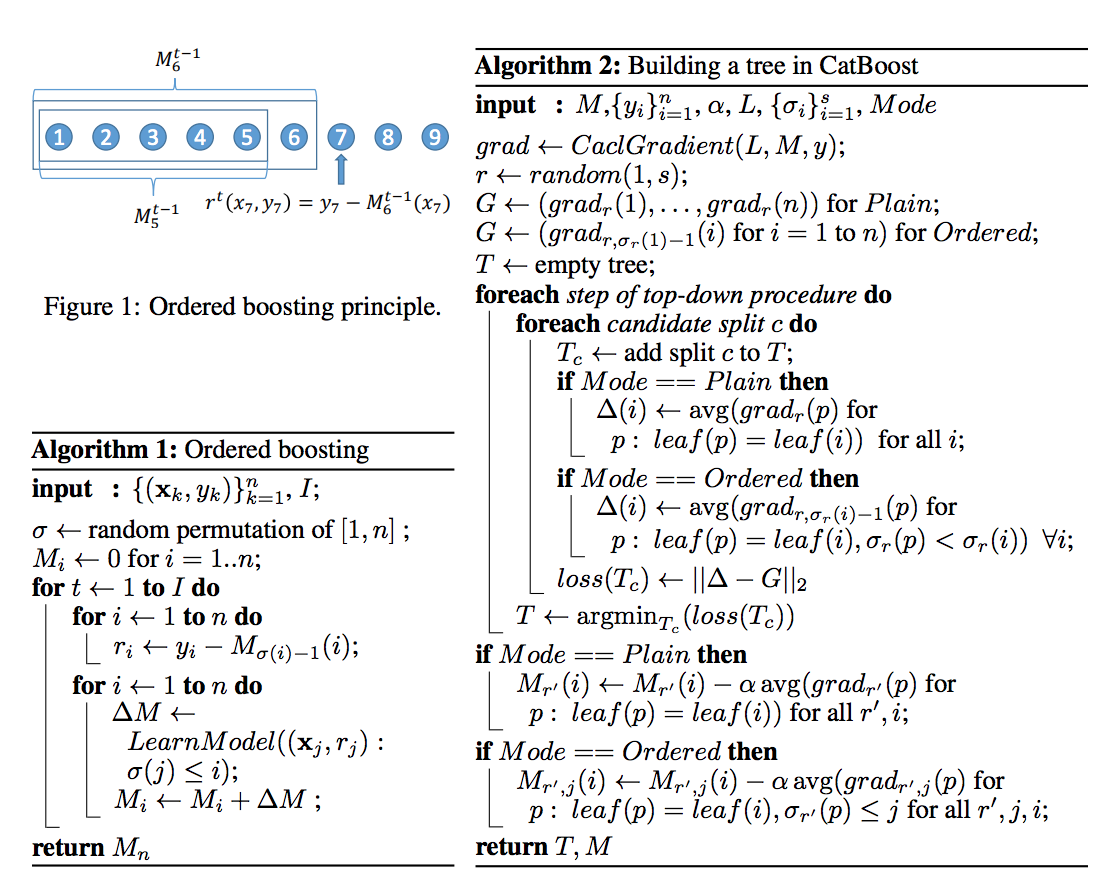

## Key Hyperparameters
* Cat Features - Indication of categorical features in dataset
* One Hot Max Size - Max number of indicators to create a one hot column
* Learning Rate - Step size in direction of gradient
* Num Estimators - Rounds of boosting (if not early stopping)

## Fit Model

In [72]:
catModel = cat.CatBoostClassifier(iterations=500, 
                          depth=6, 
                          learning_rate=0.1, 
                          early_stopping_rounds=5,
                          loss_function='Logloss')

In [73]:
X_train_cb, X_val_cb, y_train_cb, y_val_cb = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=1337)

In [74]:
cat_idx = X_train_cb.columns.get_indexer(X_train_cb.select_dtypes('object').columns)

train_pool = cat.Pool(X_train_cb, y_train_cb, cat_features=cat_idx)
val_pool   = cat.Pool(X_val_cb, y_val_cb, cat_features=cat_idx)
test_pool  = cat.Pool(X_test, cat_features=cat_idx) 

In [75]:
catModel.fit(train_pool, eval_set=val_pool)

0:	learn: 0.6896350	test: 0.6897463	best: 0.6897463 (0)	total: 303ms	remaining: 2m 31s
1:	learn: 0.6865389	test: 0.6867260	best: 0.6867260 (1)	total: 487ms	remaining: 2m 1s
2:	learn: 0.6840035	test: 0.6843028	best: 0.6843028 (2)	total: 684ms	remaining: 1m 53s
3:	learn: 0.6816588	test: 0.6818821	best: 0.6818821 (3)	total: 991ms	remaining: 2m 2s
4:	learn: 0.6796994	test: 0.6799007	best: 0.6799007 (4)	total: 1.21s	remaining: 1m 59s
5:	learn: 0.6779084	test: 0.6780865	best: 0.6780865 (5)	total: 1.42s	remaining: 1m 57s
6:	learn: 0.6763846	test: 0.6764969	best: 0.6764969 (6)	total: 1.65s	remaining: 1m 56s
7:	learn: 0.6750987	test: 0.6751676	best: 0.6751676 (7)	total: 1.94s	remaining: 1m 59s
8:	learn: 0.6738897	test: 0.6738814	best: 0.6738814 (8)	total: 2.12s	remaining: 1m 55s
9:	learn: 0.6728262	test: 0.6728134	best: 0.6728134 (9)	total: 2.29s	remaining: 1m 52s
10:	learn: 0.6719624	test: 0.6719293	best: 0.6719293 (10)	total: 2.48s	remaining: 1m 50s
11:	learn: 0.6712313	test: 0.6711886	best: 

93:	learn: 0.6573928	test: 0.6566508	best: 0.6566508 (93)	total: 20.8s	remaining: 1m 29s
94:	learn: 0.6573644	test: 0.6566263	best: 0.6566263 (94)	total: 21s	remaining: 1m 29s
95:	learn: 0.6573216	test: 0.6565736	best: 0.6565736 (95)	total: 21.2s	remaining: 1m 29s
96:	learn: 0.6573017	test: 0.6565604	best: 0.6565604 (96)	total: 21.4s	remaining: 1m 28s
97:	learn: 0.6572616	test: 0.6565261	best: 0.6565261 (97)	total: 21.6s	remaining: 1m 28s
98:	learn: 0.6572028	test: 0.6564837	best: 0.6564837 (98)	total: 21.8s	remaining: 1m 28s
99:	learn: 0.6571670	test: 0.6564429	best: 0.6564429 (99)	total: 21.9s	remaining: 1m 27s
100:	learn: 0.6571102	test: 0.6563903	best: 0.6563903 (100)	total: 22.1s	remaining: 1m 27s
101:	learn: 0.6570799	test: 0.6563638	best: 0.6563638 (101)	total: 22.3s	remaining: 1m 26s
102:	learn: 0.6570510	test: 0.6563335	best: 0.6563335 (102)	total: 22.4s	remaining: 1m 26s
103:	learn: 0.6570023	test: 0.6563129	best: 0.6563129 (103)	total: 22.6s	remaining: 1m 26s
104:	learn: 0.6

184:	learn: 0.6538159	test: 0.6544383	best: 0.6544383 (184)	total: 40.2s	remaining: 1m 8s
185:	learn: 0.6537603	test: 0.6544042	best: 0.6544042 (185)	total: 40.5s	remaining: 1m 8s
186:	learn: 0.6537128	test: 0.6543849	best: 0.6543849 (186)	total: 40.7s	remaining: 1m 8s
187:	learn: 0.6536856	test: 0.6543662	best: 0.6543662 (187)	total: 40.9s	remaining: 1m 7s
188:	learn: 0.6536652	test: 0.6543603	best: 0.6543603 (188)	total: 41.1s	remaining: 1m 7s
189:	learn: 0.6536382	test: 0.6543505	best: 0.6543505 (189)	total: 41.3s	remaining: 1m 7s
190:	learn: 0.6536024	test: 0.6543296	best: 0.6543296 (190)	total: 41.6s	remaining: 1m 7s
191:	learn: 0.6535863	test: 0.6543156	best: 0.6543156 (191)	total: 41.8s	remaining: 1m 7s
192:	learn: 0.6535372	test: 0.6542878	best: 0.6542878 (192)	total: 42s	remaining: 1m 6s
193:	learn: 0.6535029	test: 0.6542727	best: 0.6542727 (193)	total: 42.2s	remaining: 1m 6s
194:	learn: 0.6534775	test: 0.6542556	best: 0.6542556 (194)	total: 42.4s	remaining: 1m 6s
195:	learn: 

276:	learn: 0.6511676	test: 0.6533259	best: 0.6533259 (276)	total: 1m 1s	remaining: 49.2s
277:	learn: 0.6511541	test: 0.6533179	best: 0.6533179 (277)	total: 1m 1s	remaining: 49s
278:	learn: 0.6511274	test: 0.6532956	best: 0.6532956 (278)	total: 1m 1s	remaining: 48.8s
279:	learn: 0.6511122	test: 0.6532978	best: 0.6532956 (278)	total: 1m 1s	remaining: 48.6s
280:	learn: 0.6510885	test: 0.6532860	best: 0.6532860 (280)	total: 1m 2s	remaining: 48.4s
281:	learn: 0.6510505	test: 0.6532675	best: 0.6532675 (281)	total: 1m 2s	remaining: 48.2s
282:	learn: 0.6510299	test: 0.6532661	best: 0.6532661 (282)	total: 1m 2s	remaining: 48s
283:	learn: 0.6510037	test: 0.6532585	best: 0.6532585 (283)	total: 1m 2s	remaining: 47.8s
284:	learn: 0.6509584	test: 0.6532599	best: 0.6532585 (283)	total: 1m 3s	remaining: 47.6s
285:	learn: 0.6509387	test: 0.6532607	best: 0.6532585 (283)	total: 1m 3s	remaining: 47.3s
286:	learn: 0.6509186	test: 0.6532587	best: 0.6532585 (283)	total: 1m 3s	remaining: 47.1s
287:	learn: 0.

368:	learn: 0.6489963	test: 0.6525617	best: 0.6525565 (366)	total: 1m 21s	remaining: 29s
369:	learn: 0.6489677	test: 0.6525597	best: 0.6525565 (366)	total: 1m 21s	remaining: 28.8s
370:	learn: 0.6489575	test: 0.6525587	best: 0.6525565 (366)	total: 1m 22s	remaining: 28.5s
371:	learn: 0.6489319	test: 0.6525497	best: 0.6525497 (371)	total: 1m 22s	remaining: 28.3s
372:	learn: 0.6489117	test: 0.6525495	best: 0.6525495 (372)	total: 1m 22s	remaining: 28.1s
373:	learn: 0.6488842	test: 0.6525398	best: 0.6525398 (373)	total: 1m 22s	remaining: 27.8s
374:	learn: 0.6488652	test: 0.6525349	best: 0.6525349 (374)	total: 1m 22s	remaining: 27.6s
375:	learn: 0.6488458	test: 0.6525339	best: 0.6525339 (375)	total: 1m 23s	remaining: 27.4s
376:	learn: 0.6488282	test: 0.6525343	best: 0.6525339 (375)	total: 1m 23s	remaining: 27.2s
377:	learn: 0.6488143	test: 0.6525304	best: 0.6525304 (377)	total: 1m 23s	remaining: 26.9s
378:	learn: 0.6488021	test: 0.6525258	best: 0.6525258 (378)	total: 1m 23s	remaining: 26.8s
3

459:	learn: 0.6472381	test: 0.6521195	best: 0.6521195 (459)	total: 1m 41s	remaining: 8.81s
460:	learn: 0.6472204	test: 0.6521181	best: 0.6521181 (460)	total: 1m 41s	remaining: 8.59s
461:	learn: 0.6471977	test: 0.6521164	best: 0.6521164 (461)	total: 1m 41s	remaining: 8.37s
462:	learn: 0.6471634	test: 0.6521006	best: 0.6521006 (462)	total: 1m 41s	remaining: 8.15s
463:	learn: 0.6471484	test: 0.6520936	best: 0.6520936 (463)	total: 1m 42s	remaining: 7.93s
464:	learn: 0.6471257	test: 0.6520881	best: 0.6520881 (464)	total: 1m 42s	remaining: 7.7s
465:	learn: 0.6471030	test: 0.6520808	best: 0.6520808 (465)	total: 1m 42s	remaining: 7.48s
466:	learn: 0.6470793	test: 0.6520897	best: 0.6520808 (465)	total: 1m 42s	remaining: 7.27s
467:	learn: 0.6470654	test: 0.6520855	best: 0.6520808 (465)	total: 1m 43s	remaining: 7.05s
468:	learn: 0.6470381	test: 0.6520764	best: 0.6520764 (468)	total: 1m 43s	remaining: 6.83s
469:	learn: 0.6470189	test: 0.6520729	best: 0.6520729 (469)	total: 1m 43s	remaining: 6.61s


## Predict

In [76]:
pred = catModel.predict(test_pool)

## Score Model

In [77]:
acc = measureErrors(pred, y_test)
resultsDF.loc['CatBoost'] = [acc]

Accuracy 0.61573
Confusion Matrix
[[42137  7453]
 [ 6400 44010]]
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.61      0.61     49891
           1       0.62      0.62      0.62     50109

    accuracy                           0.62    100000
   macro avg       0.62      0.62      0.62    100000
weighted avg       0.62      0.62      0.62    100000



## Importance

In [78]:
importanceDF = pd.DataFrame(columns=['Feature', 'Importance'])
importanceDF['Feature'] = X_train_cb.columns
importanceDF['Importance'] = catModel.feature_importances_
importanceDF = importanceDF.sort_values('Importance', ascending=False)
importanceDF

Feature  Importance
5  SCHEDULED_DEPARTURE   16.082780
0                MONTH   15.302733
2              AIRLINE   14.798640
3       ORIGIN_AIRPORT   11.506801
4  DESTINATION_AIRPORT   11.124715
6    SCHEDULED_ARRIVAL    9.440691
7       SCHEDULED_TIME    7.622457
1          DAY_OF_WEEK    7.073152
8             DISTANCE    7.048030

<BarContainer object of 9 artists>

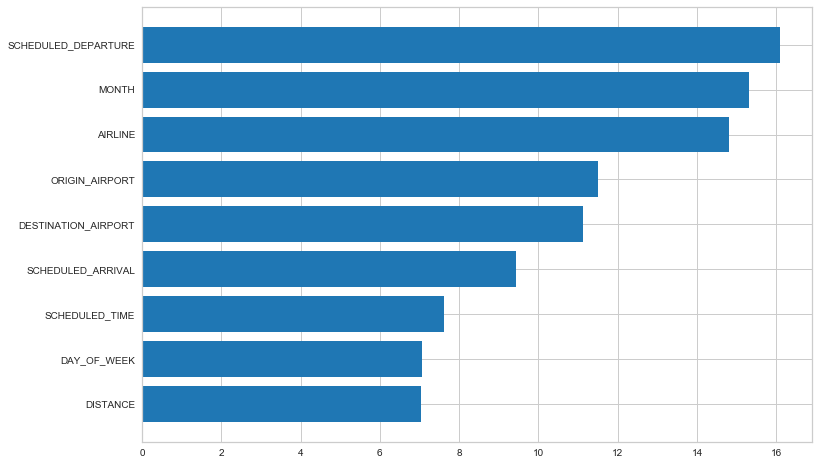

In [79]:
plt.figure(figsize=(12,8))
importanceDF = importanceDF.sort_values('Importance', ascending=True)
plt.barh(importanceDF.Feature, importanceDF.Importance, color='#1f77b4')

# Comparison
* We're beating a random coin, but this is not a terribly accurate model
* Consider feature engineering
 * Interactions
 * Routes
* Model Approach
 * Is one model for all airports great?
 * Departure or Arrival Airport Model
 * Airline Model
 * Ensemble

In [84]:
resultsDF.sort_values('Accuracy', ascending=False)

Accuracy
CatBoost   0.61573
XGBoost    0.60834
LightGBM   0.60427
AdaBoost   0.58339

# Tips & Tricks
* Boosting needs to be in your machine learning techniques
* There is variety with LightGBM and CatBoost
* Know your trees!
 * Outliers hurt boosting
 * Consider interactions
* Feature Importances
 * Can be used to feature select